In [3]:
   # mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout, Bidirectional, BatchNormalization, LeakyReLU,Masking
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from tensorflow.keras.regularizers import l2



In [5]:
#get files
df_train = pd.read_csv('/content/drive/MyDrive/train_preprocessed.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test_preprocessed.csv')
df_validation = pd.read_csv('/content/drive/MyDrive/validation_preprocessed.csv')
df_dico = pd.read_csv('/content/drive/MyDrive/dico.csv')

In [6]:
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)
print(df_dico.shape)
print(df_train.columns)


(41233, 12)
(5891, 12)
(11781, 12)
(67379, 2)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'comment_text_tokenized_sw',
       'comment_text_tokenized', 'comment_text_tokenized_swnumbered',
       'comment_text_tokenizednumbered'],
      dtype='object')


In [7]:
print(df_train.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'comment_text_tokenized_sw',
       'comment_text_tokenized', 'comment_text_tokenized_swnumbered',
       'comment_text_tokenizednumbered'],
      dtype='object')


Longueur maximale : 13384
Longueur minimale : 2
Longueur moyenne : 195.01
50e percentile (médiane) : 97.00
90e percentile : 416.80


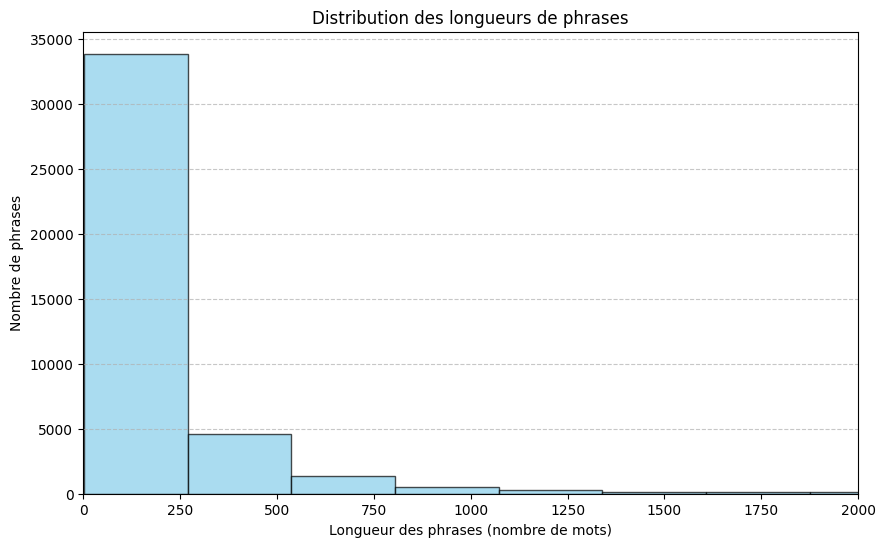

In [8]:


def plot_sentence_lengths(sentences):
    """
    Affiche un graphique des longueurs de phrases dans le dataset.

    :param sentences: Liste ou array de phrases tokenisées (liste de listes d'indices de mots).
    """
    # Calculer les longueurs des phrases
    lengths = [len(sentence) for sentence in sentences]

    # Afficher les statistiques de base
    print(f"Longueur maximale : {max(lengths)}")
    print(f"Longueur minimale : {min(lengths)}")
    print(f"Longueur moyenne : {np.mean(lengths):.2f}")
    print(f"50e percentile (médiane) : {np.median(lengths):.2f}")
    print(f"90e percentile : {np.percentile(lengths, 90):.2f}")

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Distribution des longueurs de phrases")
    plt.xlabel("Longueur des phrases (nombre de mots)")
    plt.ylabel("Nombre de phrases")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 2000)
    plt.show()

# Exemple d'utilisation avec un dataset fictif
# Remplace `X_raw` par ton dataset brut (phrases tokenisées)
X_raw = [
    [1, 2, 3],               # Phrase courte
    [4, 5, 6, 7, 8, 9],      # Phrase plus longue
    [10, 11, 12, 13] * 10,   # Phrase très longue
    [14],                    # Une phrase d'un mot
] * 100  # Multiplication pour simuler plusieurs phrases

plot_sentence_lengths(df_train['comment_text_tokenizednumbered'].to_numpy())


In [9]:


def pad_sentences_in_dataframe(df, column_name, max_length):

    if column_name not in df.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")

    # Convert strings to lists using ast.literal_eval
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Appliquer le padding sur les phrases
    padded_sequences = pad_sequences(df[column_name], maxlen=max_length, padding='post', truncating='post')

    # Ajouter les séquences paddées au DataFrame
    df_copy = df.copy()
    df_copy['padded_sequences'] = list(padded_sequences)

    return df_copy

max_sequence_length = 250

df_train_padded = pad_sentences_in_dataframe(df_train, 'comment_text_tokenizednumbered', max_sequence_length)
df_test_padded = pad_sentences_in_dataframe(df_test, 'comment_text_tokenizednumbered', max_sequence_length)
df_validation_padded = pad_sentences_in_dataframe(df_validation, 'comment_text_tokenizednumbered', max_sequence_length)

print(df_train_padded.shape)

(41233, 13)


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Classes binaires, donc calcul des poids pour chaque classe individuellement
class_weights = {}
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    # Get unique classes from the target variable
    unique_classes = np.unique(df_train_padded[column].values)

    # Compute class weights for this label
    weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=df_train_padded[column].values
    )

    # Store weights for this label in the dictionary
    class_weights[column] = {0: weights[0], 1: weights[1]}  # Create a dictionary for each label


# Convertir les poids en dictionnaire utilisable
# No change needed here, this line is correct
class_weights_dict = class_weights



In [11]:

for col, weights in class_weights_dict.items():
  print(f"Class weights for {col}: {weights}")

Class weights for toxic: {0: 0.7514944958810236, 1: 1.4940575404014784}
Class weights for severe_toxic: {0: 0.5147947463044347, 1: 17.39789029535865}
Class weights for obscene: {0: 0.6098112872692854, 1: 2.776632996632997}
Class weights for threat: {0: 0.5049227302784649, 1: 51.28482587064676}
Class weights for insult: {0: 0.5995259974409678, 1: 3.0119065010956905}
Class weights for identity_hate: {0: 0.515489823473521, 1: 16.639628732849072}


In [12]:
import tensorflow as tf
def hierarchical_loss(penalty_weight=1.0):
    """
    Fonction de perte personnalisée avec une pénalité pour erreurs hiérarchiques.
    :param penalty_weight: Poids de la pénalité pour une violation de la hiérarchie.
    """
    def loss(y_true, y_pred):
        # Calcul de la perte de base (Binary Crossentropy pour multi-label classification)
        base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Définir les relations hiérarchiques (sous-classe -> classe parent)
        parent_indices = 0  # Index de la classe 'toxic'
        sub_class_indices = [2, 3, 4, 5]  # Index des sous-classes ['obscene', 'threat', 'insult', 'identity_hate']

        # Pénalités hiérarchiques
        penalties = 0.0
        for sub_idx in sub_class_indices:
            # Si une sous-classe est détectée (y_pred > 0.5) mais pas la classe parent (toxic)
            condition = tf.logical_and(y_pred[:, sub_idx] > 0.5, y_pred[:, parent_indices] <= 0.5)
            penalties += tf.reduce_mean(tf.cast(condition, tf.float32))  # Ajoute une pénalité

        # Ajouter la pénalité pondérée à la perte
        total_loss = base_loss + penalty_weight * penalties
        return total_loss

    return loss

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, BatchNormalization, Dropout, Dense


# 1. Paramètres de base
max_vocab_size = len(df_dico)  # Nombre maximum de mots dans le vocabulaire
embedding_dim = 128     # Dimension des vecteurs d'embedding
batch_size = 256
epochs = 15

X = df_train_padded['padded_sequences'].to_numpy()
y = df_train_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_val = df_validation_padded['padded_sequences'].to_numpy()
y_val = df_validation_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_val = np.vstack(X_val)
# Assurez-vous que les séquences ont une longueur uniforme
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

# 3. Construction du modèle
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=200),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

model.compile(optimizer=AdamW(learning_rate=0.01, weight_decay=1e-4),
              loss=hierarchical_loss(penalty_weight=2.0),
              metrics=['accuracy','binary_accuracy','AUC'])

# Entraînement
history = model.fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)],
    class_weight=class_weights_dict
)



Epoch 1/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - AUC: 0.8501 - accuracy: 0.7831 - binary_accuracy: 0.8792 - loss: 0.5077 - val_AUC: 0.9661 - val_accuracy: 0.9961 - val_binary_accuracy: 0.9480 - val_loss: 0.1395 - learning_rate: 0.0100
Epoch 2/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - AUC: 0.9674 - accuracy: 0.9948 - binary_accuracy: 0.9461 - loss: 0.1399 - val_AUC: 0.9665 - val_accuracy: 0.9961 - val_binary_accuracy: 0.9483 - val_loss: 0.1385 - learning_rate: 0.0100
Epoch 3/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - AUC: 0.9727 - accuracy: 0.9960 - binary_accuracy: 0.9505 - loss: 0.1275 - val_AUC: 0.9674 - val_accuracy: 0.9961 - val_binary_accuracy: 0.9489 - val_loss: 0.1357 - learning_rate: 0.0100
Epoch 4/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - AUC: 0.9771 - accuracy: 0.9952 - binary_accuracy: 0.9539 - loss: 0.1188 - val_AUC: 0.8485 - val_accuracy: 0.9961 - val_binary_accuracy: 0.6111 - val_loss: 1.1596 - learning_rate: 0.0100
Epoch 5/15
162/162 ━━━━━━━━━━━━━

In [14]:
X_test = df_test_padded['padded_sequences'].to_numpy()
y_test = df_test_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
X_test = np.vstack(X_test)

results = model.evaluate(X_test, y_test, batch_size=batch_size)
loss = results[0]
accuracy = results[1]
binary_accuracy = results[2]
auc = results[3]


print(f"Loss: {loss}, Accuracy: {accuracy}, Binary Accuracy: {binary_accuracy}, AUC: {auc}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.9665 - accuracy: 0.9966 - binary_accuracy: 0.9478 - loss: 0.1383
Loss: 0.1374835968017578, Accuracy: 0.9959259629249573, Binary Accuracy: 0.9478300213813782, AUC: 0.9664991497993469


In [15]:


from sklearn.metrics import classification_report

# ... (your existing code) ...

X_test = df_test_padded['padded_sequences'].to_numpy()
y_test = df_test_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
X_test = np.vstack(X_test)

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int) # Convert probabilities to class labels

# Calculate and print the classification report
report = classification_report(y_test, y_pred_classes, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], output_dict=True)

#Print macro average
print(f"Macro Average:\n{report['macro avg']}")

#Print for each class
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f"Class: {label}\n{report[label]}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Macro Average:
{'precision': 0.42079421270845757, 'recall': 0.3628943603606977, 'f1-score': 0.3888554309125211, 'support': 4355.0}
Class: toxic
{'precision': 0.9047619047619048, 'recall': 0.8498714652956298, 'f1-score': 0.876458112407211, 'support': 1945.0}
Class: severe_toxic
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 175.0}
Class: obscene
{'precision': 0.8375136314067612, 'recall': 0.7420289855072464, 'f1-score': 0.7868852459016393, 'support': 1035.0}
Class: threat
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 61.0}
Class: insult
{'precision': 0.7824897400820794, 'recall': 0.5854657113613101, 'f1-score': 0.6697892271662763, 'support': 977.0}
Class: identity_hate
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 162.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

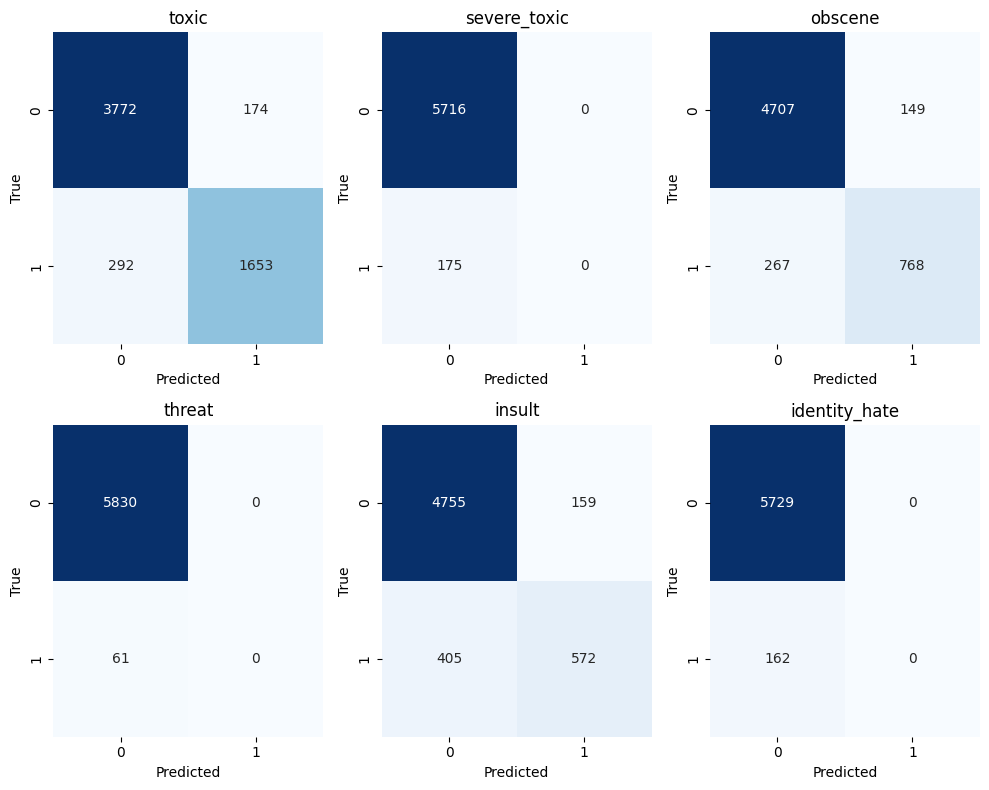

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_classes are defined as in your previous code

# Create a single heatmap for all classes
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)  # Create subplots for each class
    cm = confusion_matrix(y_test[:, i], y_pred_classes[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(df_test_padded.columns[i + 2])
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

In [17]:



model.save('/content/drive/MyDrive/categorisedToxicity.keras')
